In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import math
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.1/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.1/nvvm/lib64/libnvvm.so"
from scipy.special import erfc
import time
from tqdm.notebook import tnrange
import threading
import config as cf
from numba import jit, njit, vectorize, cuda, int16, float32
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_normal_float32


class GF():
    def __init__(self, f):
        Max = np.max(f)
        f2 = np.zeros(Max+1, np.uint8)
        f2[f] = 1
        f = np.flip(f2)
        self.len_of_symbol = Max
        self.q = 2**self.len_of_symbol
        self.table = np.array(self.make_code_table(f))
        
    def make_code_table(self, f):
        m = len(f)-1
        N = 2**m
        table = ["0"*m]
        x =""
        for i in range(1,m+1):
            if f[i]==0:
                x+="0"
            else:
                x+="1"
        for i in range(0, m):
            c="0"*m
            c = c[0:i] + "1"+c[i+1:]
            c = c[::-1]
            table.append(c)
        for i in range(m+1, N):
            a = table[-1]
            a1 = a[1:]+"0"
            b = "0"*m
            if a[0]=="1":
                b = x
            c = self.add_string_code(a1, b)
            table.append(c)
        return table
    
    def add_string_code(self, a, b):
        c =""
        for i in range(self.len_of_symbol):
            if a[i]!= b[i] :
                c+="1"
            else:
                c+="0"
        return c
    
    def reserve_e(self, a):
            a2 = self.q+1-a
            if a2 == self.q:
                a2 = 1
            if a2 == self.q+1:
                a2 = 0
            return a2
    def add(self, a, b):
        if  np.isscalar(a) and  np.isscalar(b):
            a= int(a)
            b = int(b)
            a1 = self.table[a]
            b1 = self.table[b]
            c1 = self.add_string_code(a1, b1)
            c, = np.where(self.table == c1)
            return c[0]
        elif not np.isscalar(a):
            if np.isscalar(b):
                raise ValueError("a, b must have same shape ( a:",a.shape,", b is scalar)" )
            else:
                a_size = a.shape
                b_size = b.shape
                if  len(a_size) ==2 and  len(a_size)==2:
                    if a_size[0] != b_size[0] or a_size[1] != b_size[1] :
                        raise ValueError("a, b must have same shape ( a:"+ str(a.shape) +",  b:"+str(b.shape)+ ")" )
                    else:
                        c = np.zeros_like(a, np.uint8)
                        for i in range(a_size[0]):
                            for j in range(a_size[1]):
                                c[i, j] = self.add(a[i, j], b[i, j])
                        return c
                elif len(a_size)==1 and len(b_size)==1 and a_size ==b_size :
                    c = np.zeros_like(a, np.uint8)
                    for i in range(a_size[0]):
                        c[i] = self.add(a[i], b[i])
                    return c
                else:
                    raise ValueError("a, b must have same shape ( a:"+ str(a.shape) +",  b:"+str(b.shape)+ ")" )         
    def multi(self, a, b):
        if  np.isscalar(a) and  np.isscalar(b):
                if a ==0 or b == 0:
                    return 0
                else:
                    c = (a+b-2) % (self.q-1)
                    return c+1
        elif not np.isscalar(a):
            a_size = a.shape
            if np.isscalar(b):
                c = [self.multi(i, b) for i in a]
                return np.array(c)
            b_size = b.shape
            if a_size[1] != b_size[0] :
                raise ValueError("Can not multiply 2 matrix of dimension: ", a.shape, b.shape)
            else:
                c = np.zeros((a_size[0], b_size[1]), np.uint8)
                for i in range(a_size[0]):
                    for j in range(b_size[1]):
                        for k in range(a_size[1]):
                            c[i, j] =self.add(c[i, j], self.multi(a[i, k], b[k, j])) 
                return c

gl = GF([4,  1, 0])
q = gl.q
table_str = gl.table.copy()
table = [int(i, 2) for i in table_str]
table = np.array(table)
len_of_symbol = gl.len_of_symbol
Scale = 50
dc = 5
q = 16
M = int(np.log2(q))
print("M:", M)
dtype = np.int16
H = np.load("H.npy").astype(np.int16)
m = H.shape[0]
n = H.shape[1]
k = n- m
H_non_zeros_index  = np.zeros((m, dc), np.uint16)
for i in range(m):
    stt = 0
    for j in range(n):
        if H[i, j]!=0:
            H_non_zeros_index[i, stt] = j
            stt+=1  
Hmn = np.zeros((m, dc), np.int16)  
for i in range(m):
    Hmn[i]= H[i][H_non_zeros_index[i]]
#print(Hmn)       

U_Hmn = np.zeros_like(Hmn)
for i in range(m):
    for j in range(dc):
        U_Hmn[i, j] = gl.reserve_e(Hmn[i, j])
#print(U_Hmn)
print(table_str)
print(table)
table_bits = np.array([np.array(list(i)).astype(np.int16) for i in table_str])
print(table_bits)
table_bits = cuda.to_device(table_bits)
config = cuda.to_device(np.load("config.npy"))
trellis_size = config.shape[1]+1

M: 4
['0000' '0001' '0010' '0100' '1000' '0011' '0110' '1100' '1011' '0101'
 '1010' '0111' '1110' '1111' '1101' '1001']
[ 0  1  2  4  8  3  6 12 11  5 10  7 14 15 13  9]
[[0 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 1 1]
 [0 1 1 0]
 [1 1 0 0]
 [1 0 1 1]
 [0 1 0 1]
 [1 0 1 0]
 [0 1 1 1]
 [1 1 1 0]
 [1 1 1 1]
 [1 1 0 1]
 [1 0 0 1]]


/home/bootai/miniconda3/envs/DeLai/lib/python3.6/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda-10.1/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/home/bootai/miniconda3/envs/DeLai/lib/python3.6/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda-10.1/nvvm/libdevice.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))


In [2]:
@cuda.jit(device=True)
def add_1d(a, b, c, table):
    for i in range(a.shape[0]):
        c[i]=table[a[i]]^table[b[i]]

@cuda.jit(device=True)
def add_1d_scalar(a, b, c, table):
    for i in range(a.shape[0]):
        c[i]=table[a[i]]^table[b]
        for j in range(q):
            if c[i]==table[j]:
                c[i]=j
                break

@cuda.jit(device=True)
def multi_1d_scalar(a, b, c):
    for i in range(a.shape[0]):
        if a[i]==0 and b ==0:
            c[i]=1
        else:
            c[i]=(a[i]+b-2) % (q-1)+1

@cuda.jit(device=True)
def sub_Q_permutation(sub_Q, Hmn, fix_arr0, sub_Q_permuted):
    fix_arr =cuda.local.array(shape=(dc, q),dtype=int16) ####### fix GF16
    for i in range(dc):
        multi_1d_scalar(fix_arr0, Hmn[i], fix_arr[i])
        sub_Q_permuted[0, i]=sub_Q[0, i]
        for j in range(q-1):
            sub_Q_permuted[fix_arr[i][j+1], i] = sub_Q[j+1, i]

            
@cuda.jit(device=True)
def sub_Q_selection(Q, H_index, sub_Q):
    for  x in range(sub_Q.shape[0]):
        for y in range(sub_Q.shape[1]):
            sub_Q[x, y] = Q[x, H_index[y]]

@cuda.jit(device=True)
def Zn(sub_Q, zn):
    min_arr = cuda.local.array(shape=(dc),dtype=int16)
    for i in range(dc):
        min_arr[i] = sub_Q[0, i]
        zn[i]=0
        for j in range(q):
            if min_arr[i]> sub_Q[j, i]:
                min_arr[i]=sub_Q[j, i]
                zn[i]=j
                

@cuda.jit(device=True)
def get_code(sub_Q, zn):
    min_arr = cuda.local.array(shape=(n),dtype=int16)
    for i in range(n):
        min_arr[i] = sub_Q[0, i]
        zn[i]=0
        for j in range(q):
            if min_arr[i]> sub_Q[j, i]:
                min_arr[i]=sub_Q[j, i]
                zn[i]=j

@cuda.jit(device=True)
def Delta_conversation(sub_Q, zn, fix_arr0, table, sub_Q_Delta):
    fix_arr =cuda.local.array(shape=(dc, q),dtype=int16)
    for i in range(dc):
        add_1d_scalar(fix_arr0, zn[i], fix_arr[i], table)
        for j in range(q):
            sub_Q_Delta[fix_arr[i][j], i] = sub_Q[j, i]

@cuda.jit(device=True)
def Bta(zn, B, table):
    B[0] = zn[0]
    for i in range(zn.shape[0]-1):
        add_1d_scalar(B[i], zn[i+1], B[i+1], table)

@cuda.jit(device=True)
def tree_finder_1row(A, M):
    cols = cuda.local.array(shape=(2),dtype=int16)
    values = cuda.local.array(shape=(2),dtype=int16)
    if A[0]<=A[1]:
        cols[0]=0
        cols[1]=1
        values[0]=A[0]
        values[1]=A[1]
    else:
        cols[0]=1
        cols[1]=0
        values[0]=A[1]
        values[1]=A[0]

    for i in range(2, dc):
        if A[i]<values[0]:
            values[1]=values[0]
            cols[1]=cols[0]
            values[0]=A[i]
            cols[0]=i
        elif A[i]>=values[0] and A[i]<values[1]:
            values[1]=A[i]
            cols[1]=i
    
    M[0]= values[0]
    M[1] = values[1]
    M[2]=cols[0]

@cuda.jit(device=True)
def tree_finder(A, M):
    M[0][0]= 0
    M[0][1]=0
    M[0][2]=0
    for i in range(1, q):
        tree_finder_1row(A[i], M[i])

@cuda.jit(device=True)
def trellis_building(M, config, trellis):
    for i in range(q):
        trellis[i, 0] = M[i, 0]
    for i in range(1, q):
        for j in range(1, trellis_size):
            if M[config[i, j-1, 0]][2]!=M[config[i, j-1, 1]][2]:
                trellis[i, j] = max(M[config[i, j-1, 0]][0], M[config[i, j-1, 1]][0])
            else:
                trellis[i, j]=10000

@cuda.jit(device=True)
def min_finder(A, min_out):
    min_out[0]=A[0]
    min_out[1]=0
    for i in range(1, A.shape[0]):
        if min_out[0]>A[i]:
            min_out[0]=A[i]
            min_out[1]=i

@cuda.jit(device=True)
def extra_column(trellis, M, config, extra_col):
    for i in range(q):
        min_out = cuda.local.array(shape=(2),dtype=int16)
        min_finder(trellis[i], min_out)
        extra_col[i, 0]=min_out[0]
        extra_col[i, 1]= M[i, 0]
        extra_col[i, 2]= M[i, 1]
        extra_col[i, 5]= M[i, 2]
        if i >0:
            if min_out[1]==0:
                extra_col[i, 3]=extra_col[i, 4]=M[i][2]
            else:
                extra_col[i, 3] = M[config[i, min_out[1]-1, 0]][2]
                extra_col[i, 4] = M[config[i, min_out[1]-1, 1]][2]


@cuda.jit(device=True)
def dR_computing(extra_column, dR):
    for i in range(q):
        for j in range(dc):
            if extra_column[i][3]==j or extra_column[i][4]==j:
                if extra_column[i][3]==extra_column[i][4]:
                    dR[i, j]=extra_column[i][2]
                else:
                    if extra_column[i][5]== j:
                        dR[i, j]=extra_column[i][2]
                    else:
                        dR[i, j]=extra_column[i][1]
            else:
                dR[i, j]=extra_column[i][0]

@cuda.jit(device=True)
def R_computing(dR, B, zn, R, table):
    for i in range(q):
        for j in range(dc):
            index = cuda.local.array(shape=(1),dtype=int16)
            index[0]= table[i]^table[B]^table[zn[j]]
            for l in range(q):
                if index[0] == table[l]:
                    index[0]=l
                    break
            R[index, j]=dR[i, j]

@cuda.jit(device=True)
def CN(sub_Q_permuted, zn, fix_arr, table, config, R):
    sub_Q_Delta = cuda.local.array(shape=(q, dc),dtype=int16)
    Delta_conversation(sub_Q_permuted, zn, fix_arr, table, sub_Q_Delta)
    B = cuda.local.array(shape=(dc, 1),dtype=int16)
    Bta(zn, B, table)
    #B=B[-1][0]
    M = cuda.local.array(shape=(q, 3),dtype=int16)
    tree_finder(sub_Q_Delta, M)
    trellis = cuda.local.array(shape=(q, trellis_size),dtype=int16)
    trellis_building(M, config, trellis)
    extra_columm = cuda.local.array(shape=(q, 6),dtype=int16)
    extra_column(trellis, M, config, extra_columm)
    dR = cuda.local.array(shape=(q, dc),dtype=int16)
    dR_computing(extra_columm, dR)
    R_computing(dR, B[-1][0], zn, R, table)


@cuda.jit(device=True)
def update_sub_Q(sub_Q_permuted, R, sub_Q_updated):
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            sub_Q_updated[i][j] =  sub_Q_permuted[i][j]+R[i][j]

@cuda.jit(device=True)
def subtract(Q1, Q2, Q3):
    for i in range(Q1.shape[0]):
        for j in range(Q1.shape[1]):
            Q3[i][j] =  Q1[i][j]- Q2[i][j]


@cuda.jit(device=True)
def update_Q(Q, sub_Q_updated, H_index):
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            for y in range(dc):
                if j == H_index[y]:
                    Q[i, j]=sub_Q_updated[i, y]

@cuda.jit(device=True)
def debug(X, Y):
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i, j] =X[i, j]

@cuda.jit(device=True)
def Normal(sub_Q, zn, sub_Q_normaled):
    for i in range(sub_Q.shape[0]):
        for j in range(sub_Q.shape[1]):
            sub_Q_normaled[i][j] =  sub_Q[i, j]-sub_Q[zn[j], j]

@cuda.jit(device=True)
def Normal2(sub_Q):
    for i in range(sub_Q.shape[0]):
        for j in range(sub_Q.shape[1]):
            if sub_Q[i, j]>10000:
                sub_Q[i, j]=10000

@cuda.jit(device=True)
def errors_computing(code_out, errors):
    for i in range(code_out.shape[0]):
        errors[i]=0
        for j in range(n):
            if code_out[i][j]!=0:
                errors[i]+=1


@cuda.jit(device=True)
def quick_check(code, out):
    out[0]=0
    for i in range(code.shape[0]):
        out[0]+=code[i]   

@cuda.jit(device=True)
def Decoder(Q, Hmn, U_Hmn, H_non_zeros_index, fix_arr, table, config, code_out):
    Rmna = cuda.local.array(shape=(m, q, dc),dtype=int16)
    for i in range(m):
        for j in range(q):
            for k in range(dc):
                Rmna[i][j][k]=0
    sub_Q = cuda.local.array(shape=(q, dc),dtype=int16)
    sub_Q_permuted = cuda.local.array(shape=(q, dc),dtype=int16)

    R = cuda.local.array(shape=(q, dc),dtype=int16)
    sub_Q_updated = cuda.local.array(shape=(q, dc),dtype=int16)
    sub_Q_unpermuted = cuda.local.array(shape=(q, dc),dtype=int16)
    zn = cuda.local.array(shape=(dc),dtype=int16)
    sub_Q_normaled = cuda.local.array(shape=(q, dc),dtype=int16)
    check_value = cuda.local.array(shape=(1),dtype=int16)
    
    for _iter in range(10):
        for i in range(m):
            sub_Q_selection(Q, H_non_zeros_index[i], sub_Q)
            sub_Q_permutation(sub_Q, Hmn[i], fix_arr, sub_Q_permuted)
            subtract(sub_Q_permuted, Rmna[i],  sub_Q_permuted)
            Zn(sub_Q_permuted, zn)
            Normal(sub_Q_permuted, zn, sub_Q_normaled)
            CN(sub_Q_normaled, zn, fix_arr, table, config, R)
            debug(R, Rmna[i])
            update_sub_Q(sub_Q_normaled, R, sub_Q_updated)
            #Normal2(sub_Q_updated)
            sub_Q_permutation(sub_Q_updated, U_Hmn[i], fix_arr, sub_Q_unpermuted)
            update_Q(Q, sub_Q_unpermuted, H_non_zeros_index[i])
        get_code(Q, code_out)
        quick_check(code_out, check_value)
        if check_value[0]==0:
            break

@cuda.jit
def multi_Decoder(Q, Hmn, U_Hmn, H_non_zeros_index, fix_arr, table, config, code_out, errors):
    i = cuda.grid(1)
    Decoder(Q[i], Hmn, U_Hmn, H_non_zeros_index, fix_arr, table, config, code_out[i])
    errors_computing(code_out, errors)
    
lop10e = np.log10(np.e)
@cuda.jit
def log10(A, B, C):
    i, j = cuda.grid(2)
    if i < A.shape[0] and j < A.shape[1]:
        B[i][j]= lop10e*math.log(A[i][j])
        if B[i][j]>3:
            B[i][j]=3
        C[j][i] = int(B[i][j]*100)

@cuda.jit
def probBits(bits, probBs, N0):
    i, j = cuda.grid(2)
    if i <bits.shape[0] and j < bits.shape[1]:
        d1 = abs(-1-bits[i][j])
        d2 = abs(1-bits[i][j])
        p0 = np.e**(-d1/N0)/(np.e**(-d1/N0)+np.e**(-d2/N0))
        p1 = 1-p0
        probBs[i][j][0] = p0
        probBs[i][j][1] = p1

@cuda.jit
def probS(probBs, table_bits, Q_out):
    i = cuda.grid(1)
    if i <probBs.shape[0]:
        p_max = 0
        for j in range(q):
            Q_out[i][j]=1
            for k in range(M):
                Q_out[i][j]*=probBs[i][k][table_bits[j][k]]
            if Q_out[i][j] >  p_max:
                p_max = Q_out[i][j]
        for j in range(q):
            Q_out[i][j] = p_max/Q_out[i][j]
        

@cuda.jit
def S2B(message, table_bits, bits_out):
    for i in range(message.shape[0]):
        for j in range(M):
            bits_out[i, j]= table_bits[message[i]][j]

@cuda.jit
def rand_array(rng_states, N0, out):
    thread_id = cuda.grid(1)
    x = xoroshiro128p_normal_float32(rng_states, thread_id)
    out[thread_id] = x
    out[thread_id] = out[thread_id]*N0
    out[thread_id] = out[thread_id]-1
    
@cuda.jit
def hsplit(A, B):
    i, j = cuda.grid(2)
    if i<A.shape[0] and j < A.shape[1]:
        B[j//n][i][j%n]=A[i][j]

In [3]:
batch_size = 512
fix_arr = cuda.to_device(np.arange(q))
U_Hmn = cuda.to_device(U_Hmn)
Hmn = cuda.to_device(Hmn)
H_non_zeros_index = cuda.to_device(H_non_zeros_index)
table = cuda.to_device(table)
zn = cuda.to_device(np.zeros(dc, np.int16))
code_out = cuda.to_device(np.zeros((batch_size, n), np.int16))
errors = np.zeros(batch_size, np.int16)
threads_per_block_rd = 128
blocks_rd = (n*M*batch_size+threads_per_block_rd-1)//threads_per_block_rd
rng_states = create_xoroshiro128p_states(threads_per_block_rd * blocks_rd, seed=1)

In [4]:
cf.A0 = cuda.to_device(np.zeros((batch_size*M*n), dtype=np.float32))
cf.A = cuda.to_device(np.zeros((batch_size*n , M), dtype=np.float32))
cf.B = cuda.to_device(np.zeros((batch_size*n, M, 2)))
cf.C = cuda.to_device(np.zeros((batch_size*n, q)))
cf.C2 = cuda.to_device(np.zeros((batch_size*n, q)))
cf.C3 = cuda.to_device(np.zeros((q, batch_size*n), np.int16))
cf.out = cuda.to_device(np.zeros((batch_size, q, n), np.int16))
def BPSK(sample, SNRdB):
    Eb = 1
    N0 = Eb/10**(SNRdB/10)
    sigma = np.sqrt(N0/2)
    #print(N0, sigma)
    rand_array[blocks_rd, threads_per_block_rd](rng_states, sigma, cf.A0)
    cf.A = cf.A0.reshape((batch_size*n, M))
    thread_probBits = (128, 8)
    block_probBits = ((cf.A.shape[0]+thread_probBits[0]-1)//thread_probBits[0], (cf.A.shape[1]+thread_probBits[1]-1)//thread_probBits[1])
    probBits[block_probBits, thread_probBits](cf.A, cf.B, N0)
    thread_probS = 128
    block_probS = (cf.B.shape[0]+thread_probS-1)//thread_probS
    probS[block_probS, thread_probS](cf.B, table_bits, cf.C)
    thread_log10 = (128, 8)
    block_log10 = ((cf.C.shape[0]+thread_log10[0]-1)//thread_log10[0], (cf.C.shape[1]+thread_log10[1]-1)//thread_log10[1])
    log10[thread_log10, block_log10](cf.C, cf.C2, cf.C3)
    thread_hsplit = (8, 128)
    block_hsplit = ((cf.C3.shape[0]+thread_hsplit[0]-1)//thread_hsplit[0], (cf.C3.shape[1]+thread_hsplit[1]-1)//thread_hsplit[1])
    hsplit[block_hsplit, thread_hsplit](cf.C3, cf.out)

In [5]:
def test(SNRdB, batch_size):
    eb = 0
    ef = 0
    samples = 0
    step = int(1e9//batch_size)
    for i in tnrange(step):
        BPSK(batch_size, SNRdB)
        multi_Decoder[4, batch_size//4](cf.out, Hmn, U_Hmn, H_non_zeros_index, fix_arr, table, config, code_out, errors) 
        eb+=np.sum(errors)
        for i in range(batch_size):
            if errors[i]!=0:
                ef+=1
        samples +=batch_size
        if ef>200:
            break
        if SNRdB >4 and ef>100:
            break
    print(SNRdB, samples, ef, eb, np.log10(ef/ samples), np.log10(eb/ (samples*n)))
    return samples, ef, eb


In [ ]:
SNRdB_arr = (0,  1, 2, 2.5, 3, 3.4, 3.7, 4, 4.2)
ef_arr = []
es_arr = []
S = []
for i in range(len(SNRdB_arr)):
    s, ef, es = test(SNRdB_arr[i], batch_size)
    S.append(s)
    ef_arr.append(ef)
    es_arr.append(es)


0 1024 215 2380 -0.6778614967242066 -1.5087842629750001



1 11776 206 1156 -1.7571305766242702 -2.8831012263006133


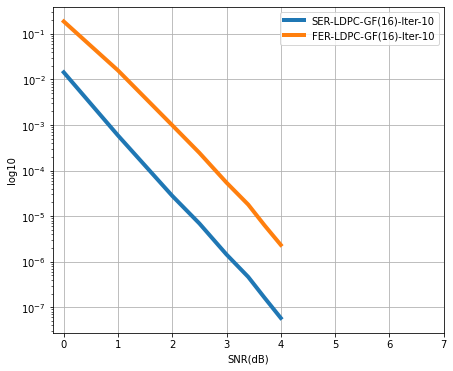

[288, 202, 201, 201, 201, 201, 201, 201]
[1653, 566, 426, 425, 399, 390, 388, 375]
[1536, 12800, 203264, 818688, 3686912, 11189248, 31827456, 85677056]


In [7]:
N = len(S)
SER = [es_arr[i]/(S[i]*n) for i in range(N)]
FER = [ef_arr[i]/(S[i]) for i in range(N)]
import  matplotlib.pyplot as plt 
fig = plt.figure(figsize=(7,6))
# plt.plot(SNRdB1, BER_BPSK, label='B-PSK', linewidth=4.0)
plt.plot(SNRdB_arr[:N], SER,'-', label='SER-LDPC-GF(16)-Iter-10', linewidth=4.0)
plt.plot(SNRdB_arr[:N], FER,'-', label='FER-LDPC-GF(16)-Iter-10', linewidth=4.0)
plt.xticks(np.arange(0, 8, 1))
plt.yscale('log')
plt.ylabel('log10')
plt.xlabel('SNR(dB)')
plt.grid()
plt.legend()
# plt.savefig('Ber.png')
# plt.close(fig)  
plt.show()
print(ef_arr)
print(es_arr)
print(S)

In [ ]:
[288, 202, 201, 201, 201, 201]
[1653, 566, 426, 404, 402, 379]
[1536, 12800, 203264, 3659776, 15742464, 86165504]